In [5]:
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
import networkx as nx
import matplotlib.pyplot as plt

In [48]:
# (global) weight parameters
a2q_weight = 0.5
c2a_weight = 0.2
c2q_weight = 0.3

# (global) datasets paths
filename_a2q = 'data/sx-stackoverflow-a2q.txt'
filename_c2a = 'data/sx-stackoverflow-c2a.txt'
filename_c2q = 'data/sx-stackoverflow-c2q.txt'


class DiGraph():
    '''
    basic directed graph
    '''
    
    def __init__(self, default_attribute = None):
        """
        internally we save it both as an adjacency list and as a list of edges
        for convenience in computation
        """
        
        def default_None_dict():
            return defaultdict(lambda : default_attribute)
        
        self.edges_list = defaultdict(lambda : default_attribute)
        self.adjacency = defaultdict(default_None_dict)
    
    @property
    def graph_type(self):
        return 'Directed Graph'
    
    def __repr__(self):
        """"""
        return 'DiGraph()'
    
    def __getitem__(self, key):
        return list(self.adjacency[key].keys())
    
    def add_node(self, node):
        self.adjacency[node]
    
    @property
    def nodes(self):
        return list(self.adjacency.keys())
    
    @property
    def edges(self):
        return list(self.edges_list.keys())
    
    def adj(self):
        return(dict(map(lambda x: (x[0], list(x[1].keys())), self.adjacency.items())))
    
    def add_edge(self, edge0, edge1):
        self.add_node(edge1)
        self.adjacency[edge0][edge1]
        self.edges_list[(edge0, edge1,)]
    
    @property
    def n_nodes(self):
        return len(self.adjacency)
    
    @property
    def n_edges(self):
        return len(self.edges_list)
    
    @property
    def get_average_links(self):
        return self.n_edges / self.n_nodes
    
    @property
    def get_density(self):
        possible_edges = self.n_nodes * (self.n_nodes - 1)
        return self.n_edges / possible_edges
    
    @property
    def isDense(self):
        is_dense = self.get_density >= 0.5
        return is_dense
    
    @property
    def isSparse(self):
        return (not self.isDense)
    
    
class weightedDiGraph(DiGraph):
    '''
    weighted directed graph
    '''
    def __init__(self):
        super().__init__(0)
    
    
    def __repr__(self):
        """"""
        return 'weightedDiGraph()'
    
    @property
    def graph_type(self):
        return 'Weighted Directed Graph'
    
    def __getitem__(self, key):
        return dict(self.adjacency[key])
    
    @property
    def edges(self):
        return list(self.edges_list.items())
    
    def adj(self):
        return(dict(map(lambda x: (x[0], dict(x[1])), self.adjacency.items())))
    
    def add_edge(self, edge0, edge1, weight):
        self.add_node(edge1)
        self.adjacency[edge0][edge1] += weight
        self.edges_list[(edge0, edge1)] += weight
    
    def union(self, another_weightedDiGraph):
        for edge, weight in another_weightedDiGraph.edges:
            self.add_edge(*edge, weight)
        
        
        
        
def search_timestamp(edges_list, time, mode):
    
    if mode == 'start':
        if edges_list[0][2] >= time:
            return(0)
        elif edges_list[-1][2] < time:
            raise ValueError('Start time too high in search_timestamp()')
    elif mode == 'end':
        if edges_list[0][2] > time:
            raise ValueError('End time too low in search_timestamp()')
        elif edges_list[-1][2] <= time:
            return(len(edges_list))
    else:
        raise ValueError('Third argument in search_timestamp() must be either "start" or "end"')
    
    
    start_idx = 0
    end_idx = len(edges_list)
    
    while (end_idx - start_idx) > 1:
        
        middle_idx = (end_idx + start_idx)//2
        
        if edges_list[middle_idx][2] < time:
            start_idx = middle_idx
            
        elif edges_list[middle_idx][2] > time:
            end_idx = middle_idx
            
        else:
            
            if mode == 'start':
                while (edges_list[middle_idx][2] == time):
                    middle_idx -= 1
                start_idx = middle_idx + 1
                return(start_idx)
            else:
                while (edges_list[middle_idx][2] == time):
                    middle_idx += 1
                start_idx = middle_idx
                return(start_idx)
    
    start_idx+=1
    
    return(start_idx)

    
class MultiDiGraph(DiGraph):
    
    def __init__(self):
        super().__init__()
    
    def __repr__(self):
        """"""
        return 'DiMultiGraph()'
    
    @property
    def graph_type(self):
        return 'Directed MultiGraph'
    
    def add_edge(self, edge0, edge1, timestamp):
        self.adjacency[edge1]
        self.adjacency[edge0][(edge1, timestamp)]
        self.edges_list[(edge0, edge1, timestamp)]
    
    def get_graph(self, filename, start_time = 0, end_time = 3000000000):
        """
        builds the graph from an input file
        """
        
        with open(filename, 'r') as file:
            for row in tqdm(file, total = 26000000):
                row = row.strip().split()
                start_node, end_node, timestamp = list(map(int, row))
                timestamp = timestamp # we should round the timestamps HERE###############################################################
                if timestamp >= start_time and timestamp <= end_time:
                    self.add_edge(start_node, end_node, timestamp)
    
    
    def get_DiGraph_from_interval(self, start_time = None, end_time = None, weight = 1):
        '''
        builds a digraph that contains only the selected time interval
        '''
        
        if start_time == None:
            start_time = self.edges[0][2]
        if end_time == None:
            end_time = self.edges[-1][2]
        
        final_graph = weightedDiGraph()
        start_edge = search_timestamp(self.edges, start_time, mode = 'start')  # returns the index of the smallest edge
                                                                               # with a timestamp bigger or equal than start_time
        
        end_edge = search_timestamp(self.edges, end_time, mode = 'end')        # returns the index of the smallest edge
                                                                               # with a timestamp smaller than end_time
        
        for edge in self.edges[start_edge : end_edge]:
            final_graph.add_edge(*(edge[0:2]), weight)
        
        return(final_graph)
    

def get_total_grap(start_time = 0, end_time = 3000000000):  # time limits of our datasets
    '''
    # onestamente non mi veniva come farlo in termini di metodi
    
    This function takes in input an interval of time and returns the
    "total" weighted digraph associated with this interval of time
    '''
    
    # MAGARI QUI POTREMMO PRENDERE IN INPUT OGGETTI TIMESTAMP E CONVERTIRLI IN EPOCH TIME
    
    # the weight parameters
    global a2q_weight
    global c2a_weight
    global c2q_weight
    
    # the datasets paths
    global filename_a2q
    global filename_c2a
    global filename_c2q
    
    # retrieve the first dataset from the disk
    print('retrieve the first dataset from the disk')
    dataset_graph = MultiDiGraph()
    dataset_graph.get_graph(filename_a2q, start_time = start_time, end_time = end_time)
    
    # select the time interval in the first dataset and build the weighted graph
    print('select the time interval in the first dataset')
    total_graph = dataset_graph.get_DiGraph_from_interval(start_time = start_time, end_time = end_time, weight = a2q_weight)
    
    # retrieve the second dataset from the disk
    print('retrieve the second dataset from the disk')
    dataset_graph = MultiDiGraph()
    dataset_graph.get_graph(filename_c2a, start_time = start_time, end_time = end_time)
    
    # join the second and the first dataset
    print('join the second and the first dataset')
    total_graph.union(dataset_graph.get_DiGraph_from_interval(start_time = start_time, end_time = end_time, weight = c2a_weight))
    
    # retrieve the third dataset from the disk
    print('retrieve the third dataset from the disk')
    dataset_graph = MultiDiGraph()
    dataset_graph.get_graph(filename_c2q, start_time = start_time, end_time = end_time)
    
    # join the third and the other two
    print('join the third and the other two')
    total_graph.union(dataset_graph.get_DiGraph_from_interval(start_time = start_time, end_time = end_time, weight = c2q_weight))
    
    return(total_graph)

Prova DiGraph()

In [49]:
prova = DiGraph()
print('Lista di adiacenza', prova.adj())
print('Nodi correnti', prova.nodes)
prova.add_node(7)
prova.add_node('7')
prova.add_node(42)
prova.add_node('la risposta')
print('Lista di adiacenza', prova.adj())
print('Nodi correnti', prova.nodes)
prova.add_edge(7, '7')
prova.add_edge(7, '7')
prova.add_edge('la risposta', 42)
prova.add_edge('la risposta', 'culo')
print('Lati correnti', prova.edges)
print('Nodi correnti', prova.nodes)
print('Lista di adiacenza', prova.adj())
print('Le risposte sono', prova['la risposta'])
print('Questo grafo è un', prova.graph_type)
print('Ci sono', prova.n_nodes, 'nodi e', prova.n_edges, 'lati')
print('Il numero medio di link è', prova.get_average_links)
print(prova)

Lista di adiacenza {}
Nodi correnti []
Lista di adiacenza {7: [], '7': [], 42: [], 'la risposta': []}
Nodi correnti [7, '7', 42, 'la risposta']
Lati correnti [(7, '7'), ('la risposta', 42), ('la risposta', 'culo')]
Nodi correnti [7, '7', 42, 'la risposta', 'culo']
Lista di adiacenza {7: ['7'], '7': [], 42: [], 'la risposta': [42, 'culo'], 'culo': []}
Le risposte sono [42, 'culo']
Questo grafo è un Directed Graph
Ci sono 5 nodi e 3 lati
Il numero medio di link è 0.6
DiGraph()


Prova WeightedDiGraph()

In [50]:
prova = weightedDiGraph()
print('Lista di adiacenza', prova.adj())
print('Nodi correnti', prova.nodes)
prova.add_node(7)
prova.add_node('7')
prova.add_node(42)
prova.add_node('la risposta')
print('Lista di adiacenza', prova.adj())
print('Nodi correnti', prova.nodes)
prova.add_edge(7, '7', 1)
prova.add_edge(7, '7', 3)
prova.add_edge('la risposta', 42, 42)
prova.add_edge('la risposta', 'culo', 17)
print('Lati correnti', prova.edges)
print('Nodi correnti', prova.nodes)
print('Lista di adiacenza', prova.adj())
print('Le risposte sono', prova['la risposta'])
print('Questo grafo è un', prova.graph_type)
print('Ci sono', prova.n_nodes, 'nodi e', prova.n_edges, 'lati')
print('Il numero medio di link è', prova.get_average_links)
print(prova)

Lista di adiacenza {}
Nodi correnti []
Lista di adiacenza {7: {}, '7': {}, 42: {}, 'la risposta': {}}
Nodi correnti [7, '7', 42, 'la risposta']
Lati correnti [((7, '7'), 4), (('la risposta', 42), 42), (('la risposta', 'culo'), 17)]
Nodi correnti [7, '7', 42, 'la risposta', 'culo']
Lista di adiacenza {7: {'7': 4}, '7': {}, 42: {}, 'la risposta': {42: 42, 'culo': 17}, 'culo': {}}
Le risposte sono {42: 42, 'culo': 17}
Questo grafo è un Weighted Directed Graph
Ci sono 5 nodi e 3 lati
Il numero medio di link è 0.6
weightedDiGraph()


In [51]:
prova2 = weightedDiGraph()
prova2.add_node(84)
prova2.add_node('9')
prova2.add_node(173)
prova2.add_node('le risposte')
prova2.add_edge(84, '7', 1)
prova2.add_edge(7, '7', 92)
prova2.add_edge('le risposte', 42, 42)
prova2.add_edge('le risposte', 'culo', 17)
prova2.add_edge('culo', 'la risposta', 91)
print('Lati correnti', prova2.edges)
print('Nodi correnti', prova2.nodes)
print('Lista di adiacenza', prova2.adj())
print('Le risposte sono', prova2['la risposta'])
print('Questo grafo è un', prova2.graph_type)
print('Ci sono', prova2.n_nodes, 'nodi e', prova2.n_edges, 'lati')
print('Il numero medio di link è', prova2.get_average_links)
print(prova2)

Lati correnti [((84, '7'), 1), ((7, '7'), 92), (('le risposte', 42), 42), (('le risposte', 'culo'), 17), (('culo', 'la risposta'), 91)]
Nodi correnti [84, '9', 173, 'le risposte', '7', 7, 42, 'culo', 'la risposta']
Lista di adiacenza {84: {'7': 1}, '9': {}, 173: {}, 'le risposte': {42: 42, 'culo': 17}, '7': {}, 7: {'7': 92}, 42: {}, 'culo': {'la risposta': 91}, 'la risposta': {}}
Le risposte sono {}
Questo grafo è un Weighted Directed Graph
Ci sono 9 nodi e 5 lati
Il numero medio di link è 0.5555555555555556
weightedDiGraph()


In [52]:
prova2.union(prova)
print('Lati correnti', prova2.edges)
print('Nodi correnti', prova2.nodes)
print('Lista di adiacenza', prova2.adj())
print('Le risposte sono', prova2['la risposta'])
print('Questo grafo è un', prova2.graph_type)
print('Ci sono', prova2.n_nodes, 'nodi e', prova2.n_edges, 'lati')
print('Il numero medio di link è', prova2.get_average_links)
print(prova2)

Lati correnti [((84, '7'), 1), ((7, '7'), 96), (('le risposte', 42), 42), (('le risposte', 'culo'), 17), (('culo', 'la risposta'), 91), (('la risposta', 42), 42), (('la risposta', 'culo'), 17)]
Nodi correnti [84, '9', 173, 'le risposte', '7', 7, 42, 'culo', 'la risposta']
Lista di adiacenza {84: {'7': 1}, '9': {}, 173: {}, 'le risposte': {42: 42, 'culo': 17}, '7': {}, 7: {'7': 96}, 42: {}, 'culo': {'la risposta': 91}, 'la risposta': {42: 42, 'culo': 17}}
Le risposte sono {42: 42, 'culo': 17}
Questo grafo è un Weighted Directed Graph
Ci sono 9 nodi e 7 lati
Il numero medio di link è 0.7777777777777778
weightedDiGraph()


Prova MultiDiGraph()

In [103]:
prova = MultiDiGraph()
print('Lista di adiacenza', prova.adj())
print('Nodi correnti', prova.nodes)
prova.add_node(7)
prova.add_node('7')
prova.add_node(42)
prova.add_node('la risposta')
print('Lista di adiacenza', prova.adj())
print('Nodi correnti', prova.nodes)
prova.add_edge(7, '7', 7)
prova.add_edge('la risposta', 42, 42)
prova.add_edge('la risposta', 'culo', 45)
prova.add_edge(7, '7', 98)
print('Lati correnti', prova.edges)
print('Nodi correnti', prova.nodes)
print('Lista di adiacenza', prova.adj())
print('Le risposte sono', prova['la risposta'])
print('Questo grafo è un', prova.graph_type)
print('Ci sono', prova.n_nodes, 'nodi e', prova.n_edges, 'lati')
print('Il numero medio di link è', prova.get_average_links)
print(prova)

Lista di adiacenza {}
Nodi correnti []
Lista di adiacenza {7: [], '7': [], 42: [], 'la risposta': []}
Nodi correnti [7, '7', 42, 'la risposta']
Lati correnti [(7, '7', 7), ('la risposta', 42, 42), ('la risposta', 'culo', 45), (7, '7', 98)]
Nodi correnti [7, '7', 42, 'la risposta', 'culo']
Lista di adiacenza {7: [('7', 7), ('7', 98)], '7': [], 42: [], 'la risposta': [(42, 42), ('culo', 45)], 'culo': []}
Le risposte sono [(42, 42), ('culo', 45)]
Questo grafo è un Directed MultiGraph
Ci sono 5 nodi e 4 lati
Il numero medio di link è 0.8
DiMultiGraph()


In [107]:
wow = prova.get_DiGraph_from_interval(start_time = 41.1, end_time = 45, weight = 1)
print(wow.adj())
print(wow.edges)

{42: {}, 'la risposta': {42: 1, 'culo': 1}, 'culo': {}}
[(('la risposta', 42), 1), (('la risposta', 'culo'), 1)]


In [116]:
filename = 'data/sx-stackoverflow-a2q.txt'
prova_dataset = MultiDiGraph()
prova_dataset.get_graph(filename)
woah1 = prova_dataset.get_DiGraph_from_interval(start_time = 1200000000, end_time = 1300000000, weight = 1)

0it [00:00, ?it/s]

In [117]:
filename = 'data/sx-stackoverflow-c2a.txt'
prova_dataset = MultiDiGraph()
prova_dataset.get_graph(filename)
woah2 = prova_dataset.get_DiGraph_from_interval(start_time = 1200000000, end_time = 1300000000, weight = 0.5)

0it [00:00, ?it/s]

In [118]:
woah1.union(woah2)

In [124]:
woah1.adj()

Questa è per prendere il grafone unito

In [7]:
# la barra di avanzamento ha un totale sbagliato,
# ci ho messo il numero più grande che poteva raggiungere tanto per avere un upper bound
# quindi è normale che si fermi prima del 100%
# è un po' poco estetico, magari poi la leviamo

# c'è una barra per ogni volta che si va a leggere il dataset dal disco
# tra le varie barre di caricamento seleziona l'intervallo di tempo e unisce i grafi
# ci mette più di quel che pensassi...
total_graph = get_total_grap(start_time = 1300050000, end_time = 1300060000)

retrieve the first dataset from the disk


  0%|          | 0/26000000 [00:00<?, ?it/s]

select the time interval in the first dataset
retrieve the second dataset from the disk


  0%|          | 0/26000000 [00:00<?, ?it/s]

join the second and the first dataset
retrieve the third dataset from the disk


  0%|          | 0/26000000 [00:00<?, ?it/s]

join the third and the other two


In [ ]:
total_graph.adj()

# Functionality 4

To solve this problem, we will going to use graph flow theory. We based our implementation and the considerations on the book "Introduction to Algorithms" by Cormen, Leiserson, Rivest, and Stein; the details and the proofs about our statement can be found there.

Given a directed weighted graph, we want to disconnect two users from each other cutting the minimum number of edges (with their weight). We will start by considering simpler cases, and we will implement an heuristic for the most general case. Before proceeding we want to make a remark: in a directed graph the statement "user A is disconnected from user B" means that there is no directed path from A to B, this implies that the fact that user A is disconnected from user B is independent of the fact that user B is disconnected from user A; our goal is to disconnect both A from B and B from A at the same time, while keeping a minimum cut on all the edges. We consider:
1. The problem of disconnecting a "source" node from a "sink" node while keeping a minimum cut on the edges
2. The problem of disconnecting a node A from a node B in a directed graph while keeping a minimum cut on the edges
3. The problem of disconnecting both a node A from a node B and node B from a node A in a directed acyclical graph while keeping a minimum cut on the edges
4. The general problem of disconnecting both a node A from a node B and node B from a node A in a directed graph while keeping a minimum cut on the edges

### 1.
The first problem in the list is easy: the max-flow min-cut theorem states that the maximum amount of flow passing from the source to the sink is equal to the total weight of the edges in the minimum cut, and, leveraging the Ford-Fulkerson method for finding the maximum flow, we can find this minimum cut removing those edges that are "saturated" in the condition of maximum flow.

### 2.
This problem is analogous to the previous one: we just miss a "source" node and a "sink" node. To solve the problem we add a source node with an edge that points to A and a large weight (virtually infinite, but every large number will be fine: we just need to be sure that it does not saturates), and a sink node with an edge that point from B to the sink and a large weight (as before). This newly obtained graph can be analyzed using the previous method, and the solution will be equivalent to the starting graph.

### 3.
We now want to disconnect both A from B and B from A, the procedure seems straightforward: disconnect A from B and B from A by applying the previous method and then join the result to get the minimum cut, this, however, may not give the optimal solution; here we give a simple example.

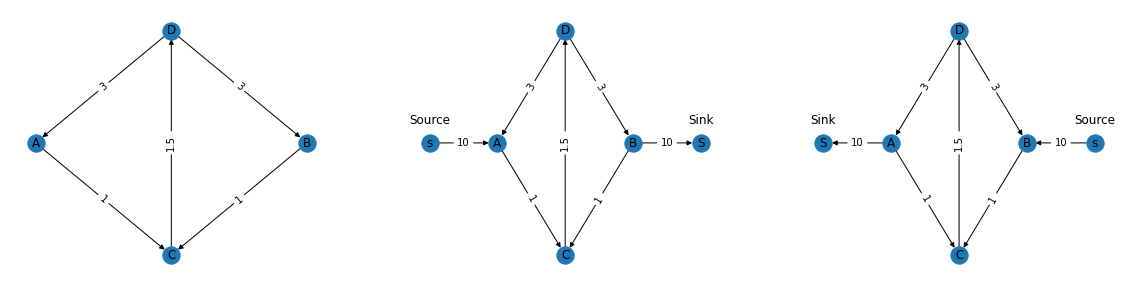

In [47]:
plt.figure(figsize = (20,5))
DG = nx.DiGraph()
DG.add_node('A',pos=(1,0))
DG.add_node('C',pos=(2,-1))
DG.add_node('D',pos=(2,1))
DG.add_node('B',pos=(3,0))
DG.add_weighted_edges_from([('A','C',1), ('C','D',1.5), ('D','A',3), ('D','B',3), ('B','C',1)])

pos_attrs = {'s':(0,0.2), 'S': (4,0.2)}
custom_node_attrs = {'s': 'Source', 'S': 'Sink'}

subax1 = plt.subplot(131)
pos=nx.get_node_attributes(DG,'pos')
nx.draw(DG,pos, with_labels = True)
nx.draw_networkx_labels(DG, pos_attrs, labels=custom_node_attrs)
labels = nx.get_edge_attributes(DG,'weight')
nx.draw_networkx_edge_labels(DG,pos,edge_labels=labels)


DG2 = nx.DiGraph()
DG2.add_node('A',pos=(1,0))
DG2.add_node('C',pos=(2,-1))
DG2.add_node('D',pos=(2,1))
DG2.add_node('B',pos=(3,0))
DG2.add_node('S',pos=(4,0))
DG2.add_node('s',pos=(0,0))
DG2.add_weighted_edges_from([('s', 'A', 10), ('B', 'S', 10), ('A','C',1), ('C','D',1.5), ('D','A',3), ('D','B',3), ('B','C',1)])

pos_attrs = {'s':(0,0.2), 'S': (4,0.2)}
custom_node_attrs = {'s': 'Source', 'S': 'Sink'}

subax2 = plt.subplot(132)
pos=nx.get_node_attributes(DG2,'pos')
nx.draw(DG2,pos, with_labels = True)
nx.draw_networkx_labels(DG2, pos_attrs, labels=custom_node_attrs)
labels = nx.get_edge_attributes(DG2,'weight')
nx.draw_networkx_edge_labels(DG2,pos,edge_labels=labels)

DG3 = nx.DiGraph()
DG3.add_node('A',pos=(1,0))
DG3.add_node('C',pos=(2,-1))
DG3.add_node('D',pos=(2,1))
DG3.add_node('B',pos=(3,0))
DG3.add_node('s',pos=(4,0))
DG3.add_node('S',pos=(0,0))
DG3.add_weighted_edges_from([('A', 'S', 10), ('s', 'B', 10), ('A','C',1), ('C','D',1.5), ('D','A',3), ('D','B',3), ('B','C',1)])

pos_attrs = {'S':(0,0.2), 's': (4,0.2)}
custom_node_attrs = {'s': 'Source', 'S': 'Sink'}

subax3 = plt.subplot(133)
pos=nx.get_node_attributes(DG3,'pos')
nx.draw(DG3,pos, with_labels = True)
nx.draw_networkx_labels(DG3, pos_attrs, labels=custom_node_attrs)
labels = nx.get_edge_attributes(DG3,'weight')
nx.draw_networkx_edge_labels(DG3,pos,edge_labels=labels)

plt.show()

In this case, applying the Ford Fulkerson method to the first graph means applying it to the second and to the third, and then joining the result. In the second graph the optimal solution is removing the edge from A to C, while in the second is the edge from B to C. So removing this two edges from the original graph would disconnect A and B with a total cost of of 2, but the optimal solution would be removing just the edge from C to D (with a total cost of 1.5). The problem here is that exists two paths (one from A to B and the other from B to A) that have a common edge, which is equivalent to the existence of two distinct cycles (one that contains A and not B, and another that contains B and not A) that have a common edge. So this last case would be our exact hypotesis; in this framework, as said before, to find the optimal solution we can just apply the Ford Fulkerson method twice and join the solutions.

### 4.
We did not manage to find an algorithm to solve the general problem and that does not involve checking all the possible combinations of cuts. For this reason, we provide an heuristic: upon starting the algorithm we search for all the possible couple of cycles containing A and B, we intersect each possible pairs and collect a set of edges, we remove the one with the lighter weight, and then we repeat until there are no common edges left. At this point we can proceed as described in the previous case.

This is a very simple heuristic, and can easily fail (for example in the graph above by substituing the weights 1 with 0.5), it is though a useful step of simplification in the problem, and we did not feel like neither spending more time on it, nor adding another layer of complexity to the algorithm. Moreover, specifically for this last reason, we decided to implement the Ford Fulkerson method for finding the maximum flow, instead of the faster Push Relabel or Push to Front algorithms.

In [53]:
def functionality4(interval1, interval2, user1, user2):
    heuristc = False
    
    total_graph = get_total_grap(*interval1)
    total_graph.union(get_total_grap(*interval2))
    
    cycle_edges = remove_cycles(total_graph, user1, user2)
    
    edges = find_min_cut(total_graph, user1, user2)
    
    if len(cycle_edges)>0:
        heuristc = True
        edges.update(cycle_edges)
    
    
    total_cost = 0
    for edge in edges:
        total_cost += total_graph.edges_list[edge]
    
    return heuristc, total_cost, edges

def find_min_cut(graph, user1, user2):
    
    cut_1_to_2 = find_min_cut_A_to_B(graph, user1, user2)
    cut_2_to_1 = find_min_cut_A_to_B(graph, user2, user1)

    return( set.union(cut_1_to_2, cut_2_to_1) )

def find_min_cut_A_to_B(graph, user1, user2):
    
    # the weight of the edge from the source to user1 will be
    # greater than the sum of all the outgoing weights from user1
    source_weight = 1
    for weights in graph.adjacency[user1].values():
        source_weight += weight
    graph.add_edge('source', user1, source_weight)
    
    # it is sufficient to have sink_weight == source_weight for these
    # nodes to not influence the outcome of the algorithm
    sink_weight = source_weight
    graph.add_edge(user2, 'sink', sink_weight)
    
    flow = find_max_flow(graph)
    
    graph.remove('source')
    graph.remove('sink')
    
    selected_edges = set()
    for edge, weight in graph.edges_list.items():
        if flow[edge] == weight:
            selected_edges.add(edge)
    
    return(selected_edges)

def remove_cycles(total_graph, user1, user2):
    common_edges = set()
    
    
    return common_edges

def find_max_flow(graph, source = 'source', sink = 'sink'):
    flow_dict = defaultdict(lambda x: 0) # maybe?
    
    
    return (flow_dict)